In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import convolve2d
import cv2

digits = load_digits()
#Chaque ligne représente une image à plat (flattened en 1D), donc une observation.
print("Dimensions des données :")
print("- digits.data.shape :", digits.data.shape)  
print("- digits.images.shape :", digits.images.shape)  
print("Nombre de classes :", len(np.unique(digits.target))) 

X = digits.data
y = digits.target
# Print dataset shape
print(f"\nFeature matrix shape: {X.shape}. Max value = {np.max(X)}, Min value = {np.min(X)}, Mean value = {np.mean(X)}")
print(f"Labels shape: {y.shape}") 

Dimensions des données :
- digits.data.shape : (1797, 64)
- digits.images.shape : (1797, 8, 8)
Nombre de classes : 10

Feature matrix shape: (1797, 64). Max value = 16.0, Min value = 0.0, Mean value = 4.884164579855314
Labels shape: (1797,)


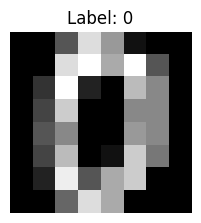

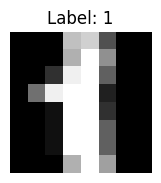

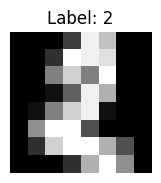

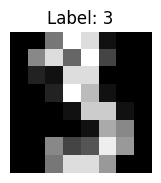

In [155]:
# Visualize some images
# TODO: Graph the first4 images from the data base 
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f"Label: {digits.target[i]}")
    plt.axis('off') 
    plt.tight_layout()
    plt.show()

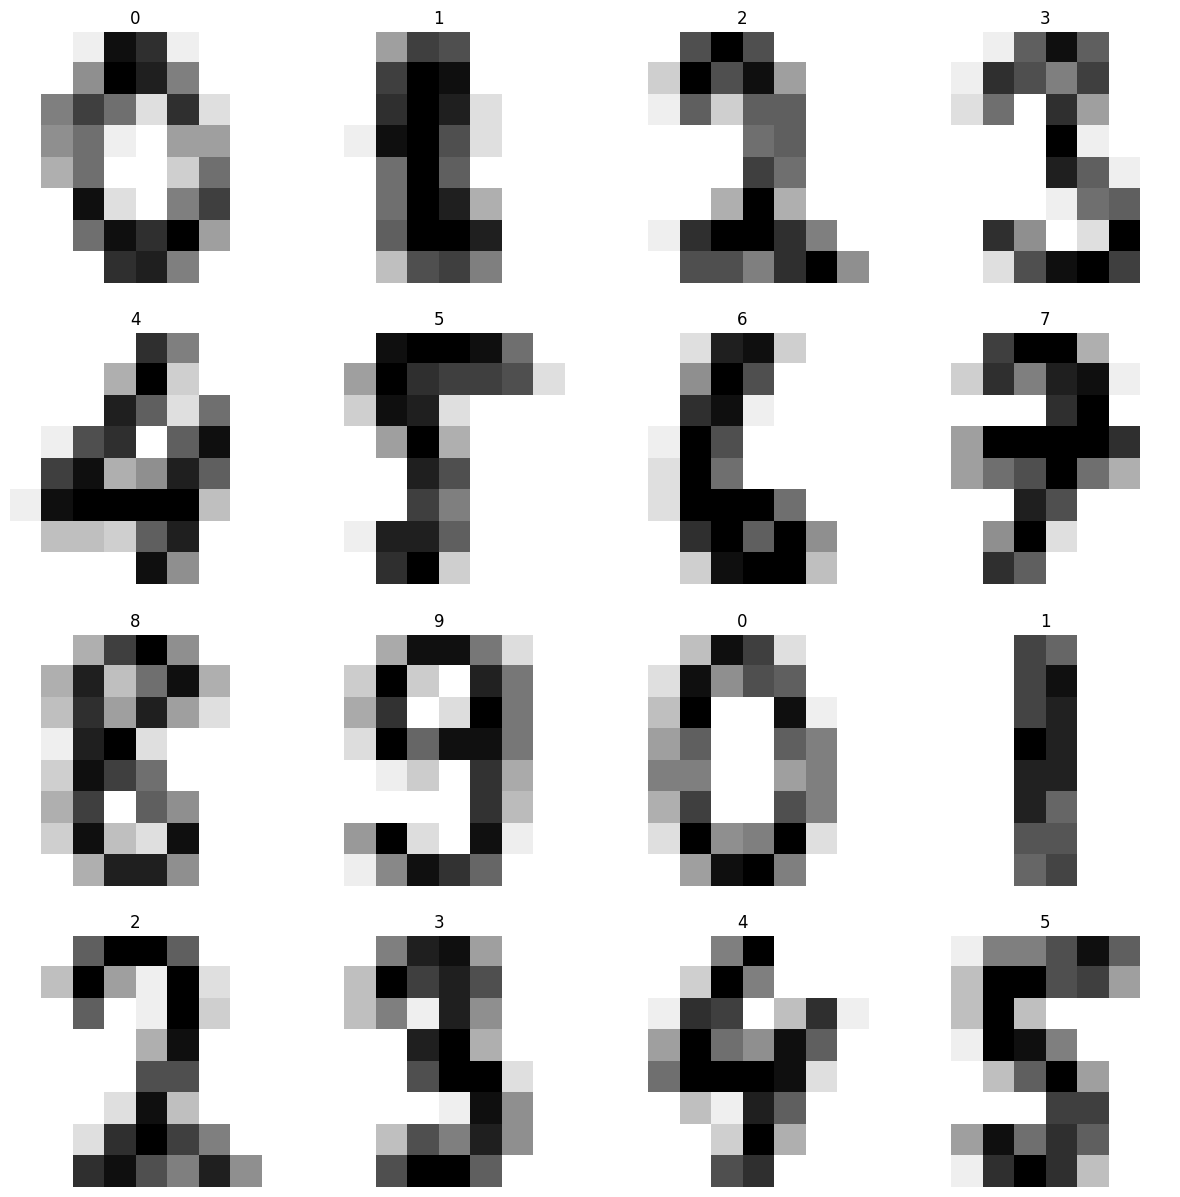

In [156]:
def plot_multi(data, y):
    '''Plots 16 digits'''
    nplots = 16
    nb_classes = len(np.unique(y))
    cur_class = 0
    fig = plt.figure(figsize=(15,15))
    for j in range(nplots):
        plt.subplot(4,4,j+1)
        to_display_idx = np.random.choice(np.where(y == cur_class)[0])
        plt.imshow(data[to_display_idx].reshape((8,8)), cmap='binary')
        plt.title(cur_class)
        plt.axis('off')
        cur_class = (cur_class + 1) % nb_classes
    plt.show()


plot_multi(digits.data, digits.target)

In [157]:
def get_statistics_text(targets):
    unique, counts = np.unique(targets, return_counts=True)
    stats = []
    for u, c in zip(unique, counts):
        stats.append(f"Class {u}: {c} samples")
    return "\n".join(stats)

print("Statistiques sur les classes :")
print(get_statistics_text(digits.target))

Statistiques sur les classes :
Class 0: 178 samples
Class 1: 182 samples
Class 2: 177 samples
Class 3: 183 samples
Class 4: 181 samples
Class 5: 182 samples
Class 6: 181 samples
Class 7: 179 samples
Class 8: 174 samples
Class 9: 180 samples


Text(0.5, 1.0, 'Distribution des classes')

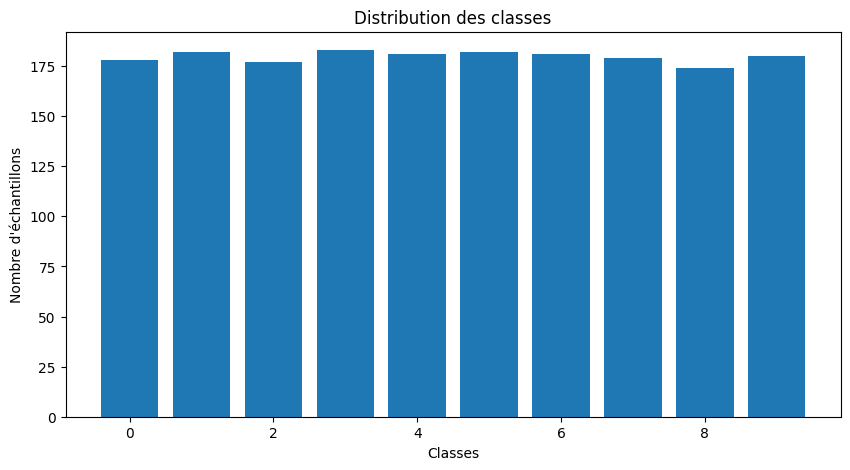

In [158]:
# BarPlot pour afficher la distribution des classes
plt.figure(figsize=(10, 5))
plt.bar(*np.unique(digits.target, return_counts=True))
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes")   

In [159]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(digits.data)

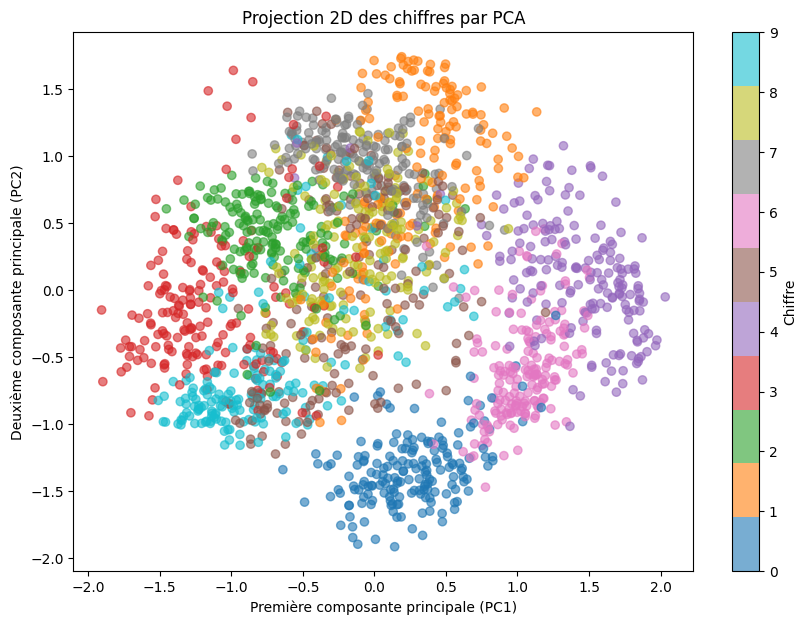

In [160]:
# PCA à 2 composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)  
#print(pca.explained_variance_ratio_)
# Affichage 2D avec coloration par classe
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Chiffre')
plt.xlabel("Première composante principale (PC1)")
plt.ylabel("Deuxième composante principale (PC2)")
plt.title("Projection 2D des chiffres par PCA")
plt.show()

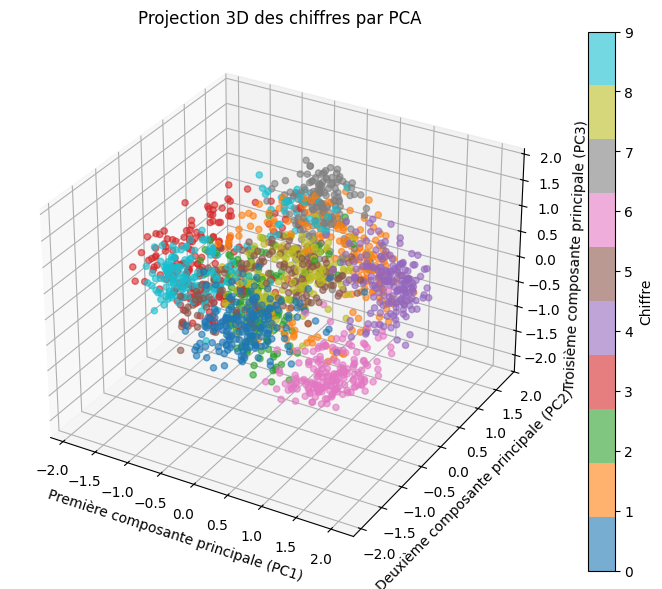

In [161]:
# PCA à 3 composantes principales
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_normalized)  
#print(pca3.explained_variance_ratio_)
# Affichage 3D avec coloration par classe
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=digits.target, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Chiffre')
ax.set_xlabel("Première composante principale (PC1)")
ax.set_ylabel("Deuxième composante principale (PC2)")
ax.set_zlabel("Troisième composante principale (PC3)")
plt.title("Projection 3D des chiffres par PCA")
plt.show()

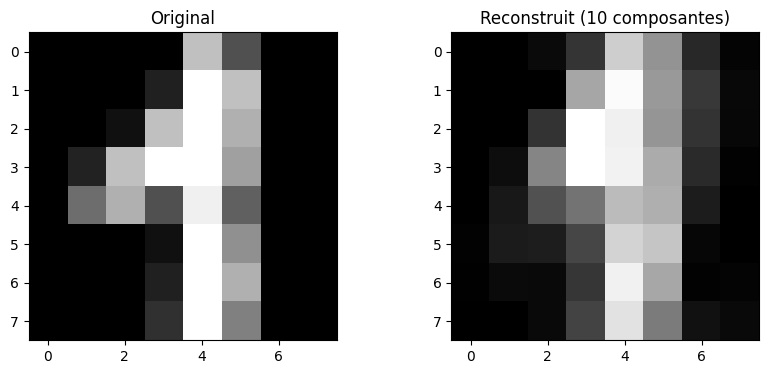

In [162]:
# PCA avec n_components=10 (choisi arbitrairement)
pca_reconstruct = PCA(n_components=10)
X_pca_reduced = pca_reconstruct.fit_transform(X_normalized)
X_reconstructed = pca_reconstruct.inverse_transform(X_pca_reduced)

# Affichage d'un exemple
sample_idx = 42  # Image test
original = X_normalized[sample_idx].reshape(8, 8)
reconstructed = X_reconstructed[sample_idx].reshape(8, 8)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(original, cmap='gray', vmin=0, vmax=1)
axes[0].set_title("Original")
axes[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f"Reconstruit (10 composantes)")
plt.show()

In [163]:
# evaluer la qualité de la reconstruction
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(original, reconstructed)
print(f"Erreur quadratique moyenne (MSE) de la reconstruction : {mse:.4f}")
# Afficher la variance expliquée par les composantes principales
print("Variance expliquée par les composantes principales :")
print(pca_reconstruct.explained_variance_ratio_)

Erreur quadratique moyenne (MSE) de la reconstruction : 0.0219
Variance expliquée par les composantes principales :
[0.14815157 0.13523675 0.11706654 0.08316524 0.05736613 0.0485009
 0.04252881 0.03677515 0.03323376 0.03046634]


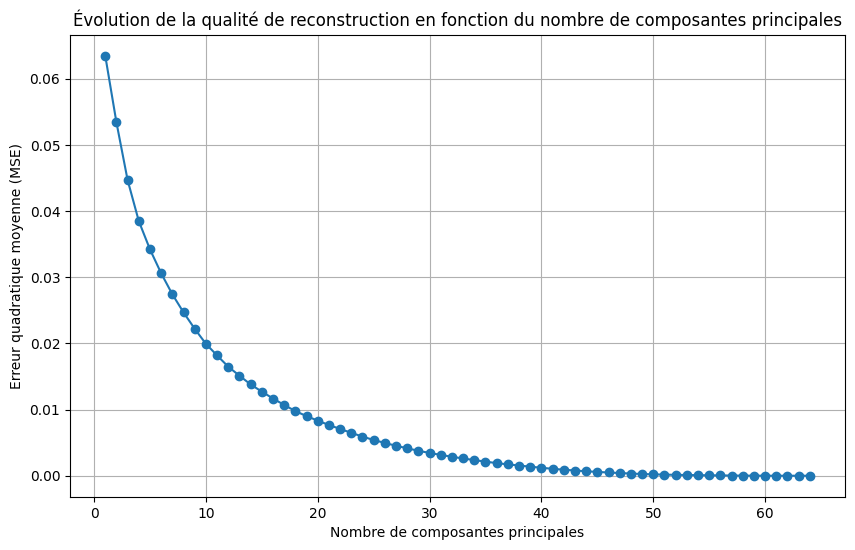

In [164]:
def evolution_quality():
    """Affiche l'évolution de la qualité de reconstruction en fonction du nombre de composantes principales."""
    n_components = np.arange(1, 65)  # De 1 à 64
    mse_values = []

    for n in n_components:
        pca_temp = PCA(n_components=n)
        X_pca_temp = pca_temp.fit_transform(X_normalized)
        X_reconstructed_temp = pca_temp.inverse_transform(X_pca_temp)
        mse = mean_squared_error(X_normalized, X_reconstructed_temp)
        mse_values.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(n_components, mse_values, marker='o')
    plt.title("Évolution de la qualité de reconstruction en fonction du nombre de composantes principales")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Erreur quadratique moyenne (MSE)")
    plt.grid()
    plt.show()
evolution_quality()



In [165]:
# Partitionnement d'image en 3 zones 

def extract_zone_features(img):
    zone_haut = img[0:3, :]     #
    zone_milieu = img[3:5, :] 
    zone_bas = img[5:8, :]      

    moy_haut = np.mean(zone_haut)
    moy_milieu = np.mean(zone_milieu)
    moy_bas = np.mean(zone_bas)
    features = [moy_haut, moy_milieu, moy_bas]
    return features


img2= digits.data[1].reshape(8, 8)  # Prendre la première image en 2D
img3 = digits.data[56].reshape(8, 8)  # Prendre la première image en 2D
features2 = extract_zone_features(img2)
features3 = extract_zone_features(img3)
print("Caractéristiques extraites de l'image 2D partitionnée :", features2)
print("Caractéristiques extraites de l'image 2D partitionnée :", features3)

Caractéristiques extraites de l'image 2D partitionnée : [np.float64(4.416666666666667), np.float64(5.75), np.float64(4.791666666666667)]
Caractéristiques extraites de l'image 2D partitionnée : [np.float64(5.041666666666667), np.float64(6.375), np.float64(3.0833333333333335)]


In [166]:

## Edge detection features
def detection_contours(img):
    # Définir le filtre de Sobel
    filtre_sobel = np.array([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]])
    # Appliquer le filtre de Sobel
    img_filtrée = convolve2d(img, filtre_sobel, mode='same', boundary='symm')
    return img_filtrée




<Figure size 1000x500 with 0 Axes>

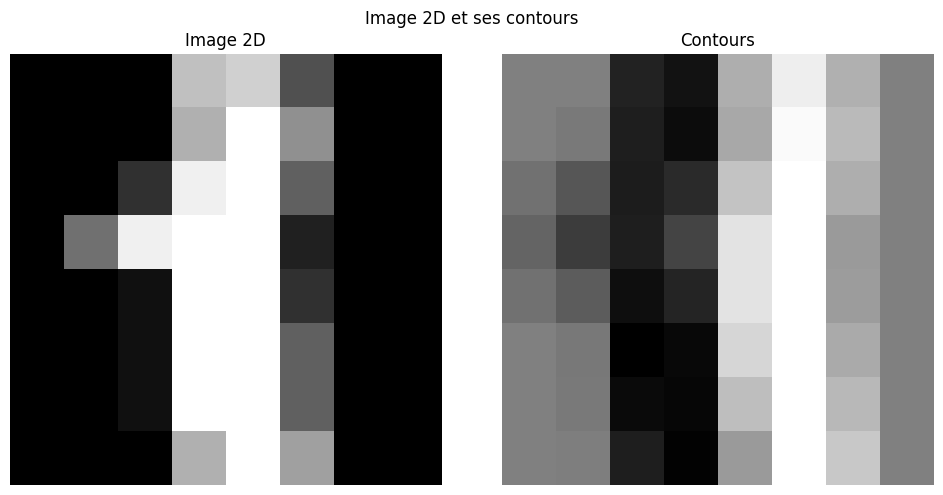

In [167]:
img2 = digits.data[1].reshape(8, 8)  # Prendre la première image en 2D
contours2 = detection_contours(img2)
def plot(img1, img2, title, label1, label2):
    """Affiche deux images côte à côte."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(label1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(label2)
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(10, 5))
plot(img2, contours2, "Image 2D et ses contours", "Image 2D", "Contours")


In [168]:

def gradient_features(image):
    # Appliquer Sobel
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    return magnitude

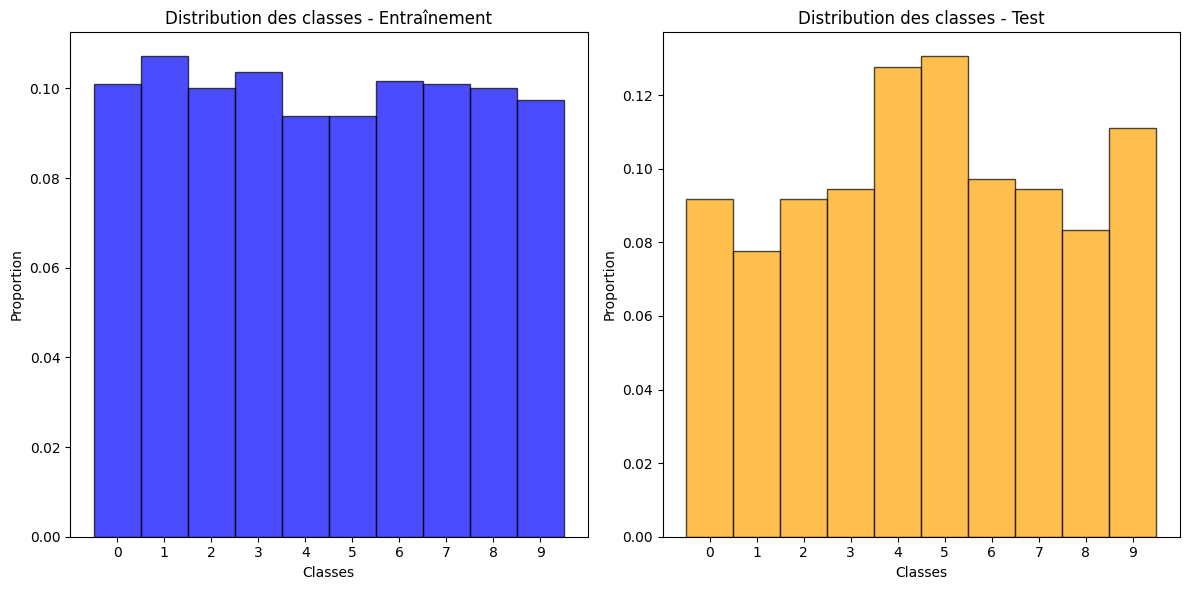

In [169]:
# train split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
#evaluer les distributions des classes dans les ensembles d'entraînement et de test
def plot_class_distribution(y_train, y_test):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_train, bins=np.arange(11) - 0.5, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribution des classes - Entraînement')
    plt.xlabel('Classes')
    plt.ylabel('Proportion')
    plt.xticks(np.arange(10))

    plt.subplot(1, 2, 2)
    plt.hist(y_test, bins=np.arange(11) - 0.5, density=True, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Distribution des classes - Test')
    plt.xlabel('Classes')
    plt.ylabel('Proportion')
    plt.xticks(np.arange(10))

    plt.tight_layout()
    plt.show()
plot_class_distribution(y_train, y_test)

In [170]:
# concaténation en utilisant hstack
features1 = pca.transform(X_train)  # PCA features
features2=extract_zone_features(X_train)
features3=gradient_features(X_train)

def matrice_concatenate(features1, features2, features3):
    return np.hstack((features1, features2, features3))


In [171]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.ndimage import sobel


class EdgeInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''Average Sobel filter (edge intensity) as feature'''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array([np.mean(sobel(img.reshape((8,8)))) for img in X]).reshape(-1, 1)
    

class ZonalInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''Mean intensity in 4 image zones (top-left, top-right, bottom-left, bottom-right)'''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        zonal_features = []
        for img in X:
            img2d = img.reshape((8, 8))
            zone_haut = img2d[0:3, :]
            zone_milieu = img2d[3:5, :]
            zone_bas = img2d[5:8, :]

            moy_haut = np.mean(zone_haut)
            moy_milieu = np.mean(zone_milieu)
            moy_bas = np.mean(zone_bas)
            zonal_features.append([moy_haut, moy_milieu, moy_bas])
        return np.array(zonal_features)


In [186]:
all_features = FeatureUnion([
    ("pca", PCA(n_components=30)),
    ("edges", EdgeInfoPreprocessing()),
    ("zones", ZonalInfoPreprocessing())
])

# Vérification : transformation uniquement sur X_train
F = all_features.fit(X_train, y_train).transform(X_train)
print("Nb features computed: ", F.shape[1])  



Nb features computed:  34


In [183]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("features", all_features),
    ("classifier", SVC(kernel='linear'))
])

# Entraînement
clf.fit(X_train, y_train)
predict_test = [1]*len(X_test)
predict_train = [1]*len(X_train)

print("Accuracy of the SVC on the test set: ", sum(y_test==predict_test)/len(y_test))
print("Accuracy of the SVC on the train set: ", sum(y_train==predict_train)/len(y_train))

#2éme evaluation avec Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error  
MAE= mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE) sur test set :", MAE)


Accuracy of the SVC on the test set:  0.07777777777777778
Accuracy of the SVC on the train set:  0.10716771050800278
Mean Squared Error (MSE) sur test set : 0.05


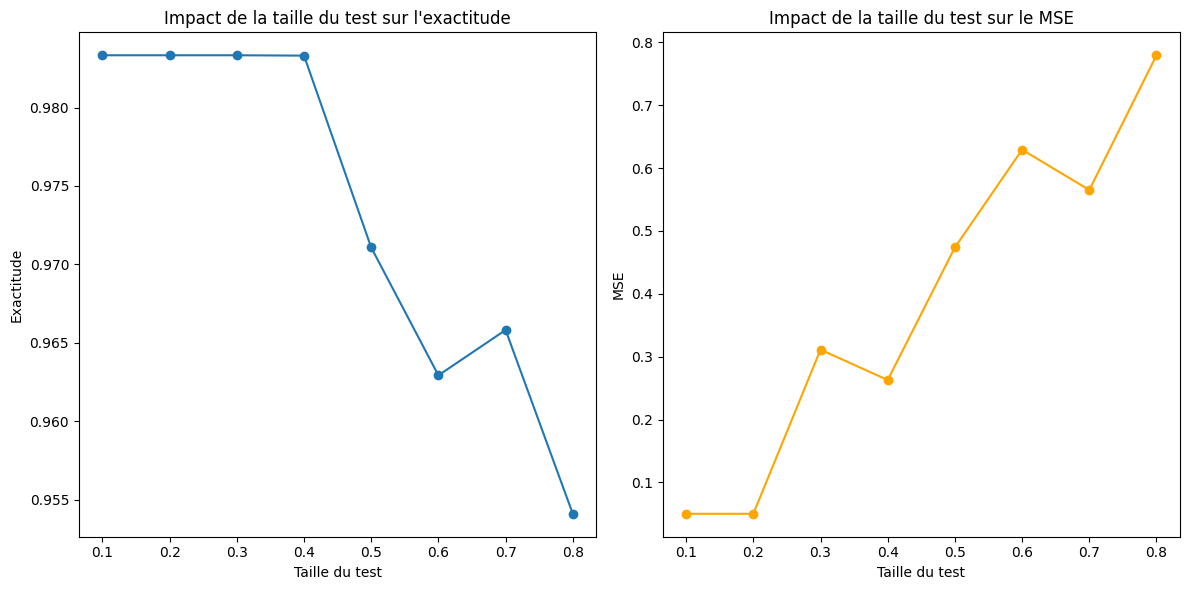

In [ ]:
#influence de test_size sur la performance du modèle
def evaluate_model(test_size):
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, mse

def plot_test_size_effect():
    test_sizes = np.arange(0.1, 0.9, 0.1)
    accuracies = []
    mses = []

    for size in test_sizes:
        accuracy, mse = evaluate_model(size)
        accuracies.append(accuracy)
        mses.append(mse)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(test_sizes, accuracies, marker='o')
    plt.title('Impact de la taille du test sur l\'exactitude')
    plt.xlabel('Taille du test')
    plt.ylabel('Exactitude')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_sizes, mses, marker='o', color='orange')
    plt.title('Impact de la taille du test sur le MSE')
    plt.xlabel('Taille du test')
    plt.ylabel('MSE')

    plt.tight_layout()
    plt.show()
plot_test_size_effect()

In [185]:
from sklearn.svm import SVC

pipeline2 = Pipeline([
    ("features", all_features),              
    ("scaler", MinMaxScaler()),             
    ("classifier", SVC(kernel='rbf'))        
])

#Create a dictionary with all the parameters to be adapted and the ranges to be tested

param_grid = {
    "features__pca__n_components": [10, 20, 30, 40],  
    "classifier__C": [0.1, 1, 10, 100],               
    "classifier__gamma": [0.01, 0.1, 1, 10],          
}



In [184]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipeline2, param_grid, cv=5, scoring="accuracy", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 1, 'features__pca__n_components': 30}
Best cross-validation score: 0.9909504452187379


In [ ]:
# Validation croisée (5-fold)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Score moyen CV :", cv_scores.mean())